In [1]:
import pandas as pd 
import networkx as nx 
from gsnn.simulate.nx2pyg import nx2pyg
from gsnn.models.GSNN import GSNN
from gsnn.models.NN import NN
import numpy as np 
import torch 
from scipy.stats import spearmanr 
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from sklearn.metrics import r2_score 
from matplotlib import pyplot as plt 
from gsnn.interpret.GSNNExplainer import GSNNExplainer
from gsnn.interpret.ContrastiveIGExplainer import ContrastiveIGExplainer
from gsnn.interpret.CounterfactualExplainer import CounterfactualExplainer
from gsnn.interpret.NoiseTunnel import NoiseTunnel
import umap

from sklearn.decomposition import PCA
import seaborn as sbn 

torch.manual_seed(0)
np.random.seed(0)

%load_ext autoreload
%autoreload 2

/home/teddy/miniconda3/envs/gsnn-mds/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# DrugCell implementation example 

In this tutorial, we will implement the drugcell model using a GSNN and train using their provided [data](https://github.com/idekerlab/DrugCell/tree/public/data). 

```
Predicting Drug Response and Synergy Using a Deep Learning Model of Human Cancer Cells.Kuenzi, Brent M. et al. Cancer Cell, Volume 38, Issue 5, 672 - 684.e6
```

The code below assumes you have cloned the drugcell [repo](https://github.com/idekerlab/DrugCell.git), and the `drugcell_path` is set correctly below. 



In [2]:
drugcell_path = '/home/teddy/local/DrugCell/'

In [3]:
cell2ind = pd.read_csv(f'{drugcell_path}/data/cell2ind.txt', sep='\t', header=None, index_col=0)
cell2mut = pd.read_csv(f'{drugcell_path}/data/cell2mutation.txt', sep=',', header=None) 
drug2ind = pd.read_csv(f'{drugcell_path}/data/drug2ind.txt', sep='\t', header=None, index_col=0)
drugcell_ont = pd.read_csv(f'{drugcell_path}/data/drugcell_ont.txt', sep='\t', header=None).rename(columns={0:'target', 1:'source', 2:'edge_type'})
gene2ind = pd.read_csv(f'{drugcell_path}/data/gene2ind.txt', sep='\t', header=None, index_col=0)

drugcell_train = pd.read_csv(f'{drugcell_path}/data/drugcell_train.txt', sep='\t', header=None)  
drugcell_test = pd.read_csv(f'{drugcell_path}/data/drugcell_test.txt', sep='\t', header=None)   
drugcell_val = pd.read_csv(f'{drugcell_path}/data/drugcell_val.txt', sep='\t', header=None)    

In [4]:
# zscore y 
y_mu = drugcell_train[2].mean() 
y_std = drugcell_train[2].std() 

drugcell_train[2] = (drugcell_train[2] - y_mu) / y_std 
drugcell_test[2] = (drugcell_test[2] - y_mu) / y_std 
drugcell_val[2] = (drugcell_val[2] - y_mu) / y_std 


In [5]:
input_nodes = gene2ind[1].values.tolist()
function_nodes = list(set(drugcell_ont[lambda x: x.edge_type == 'default'].source.tolist()).union(set(drugcell_ont[lambda x: x.edge_type == 'default'].target.tolist()))) 
output_nodes = [f'OUT{i}__GO:0008150' for i in range(6)] # 32 cell dim 

print(f'{len(input_nodes)} input nodes')
print(f'{len(function_nodes)} function nodes')
print(f'{len(output_nodes)} output nodes')

3008 input nodes
2086 function nodes
6 output nodes


In [6]:
G = nx.DiGraph() 
for i, row in drugcell_ont.iterrows():
    G.add_edge(row['source'], row['target'], edge_type='input')

# add multiple output nodes to create multidimensional mutation representation 
for out in output_nodes: 
    G.add_edge('GO:0008150', out) 

print(f'# nodes: {len(G)}')
print(f'# edges: {len(G.edges())}')

# nodes: 5100
# edges: 62926


In [7]:
data = nx2pyg(G, input_nodes, function_nodes, output_nodes) 

In [8]:
class DrugCellDataset(torch.utils.data.Dataset):

    def __init__(self, data, cell2code, drug2code): 

        self.data = data.reset_index(drop=True) 
        self.cell2code = cell2code 
        self.drug2code = drug2code 

    def __len__(self): 
        return len(self.data) 
    
    def __getitem__(self, idx): 
        obs = self.data.iloc[idx] 

        x_cell = torch.tensor(self.cell2code[obs[0]], dtype=torch.float32)
        x_drug = torch.tensor(self.drug2code[obs[1]], dtype=torch.float32)
        y = torch.tensor(obs[2], dtype=torch.float32)  

        return x_cell, x_drug, y 

In [9]:
drug2code = {} 
smiles = np.unique( drugcell_train[1].tolist() + drugcell_test[1].tolist() + drugcell_val[1].tolist()) 
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048) 

for i, s in enumerate(smiles):  
    print(f'{i}/{len(smiles)}', end='\r')
    mol = Chem.MolFromSmiles(s)
    fp = mfpgen.GetFingerprint(mol) 
    code = np.array(fp.ToList(), dtype=np.float32)
    drug2code[s] = code 


cell2code = {} 
cell_muts = cell2mut.merge(cell2ind.rename(columns={1:'cell_id'}), left_index=True, right_index=True)  
for i, row in cell_muts.iterrows(): 
    print(f'{i}/{len(cell2mut)}', end='\r')
    cell2code[row['cell_id']] = np.array(row.values[:-1], dtype=np.float32)

In [10]:
train_dataset = DrugCellDataset(drugcell_train, cell2code, drug2code)
test_dataset = DrugCellDataset(drugcell_test, cell2code, drug2code)
val_dataset = DrugCellDataset(drugcell_val, cell2code, drug2code)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=512, shuffle=False)

print(f'{len(train_dataset)} train samples')
print(f'{len(test_dataset)} test samples')
print(f'{len(val_dataset)} val samples')
print(f'{len(train_dataset) + len(test_dataset) + len(val_dataset)} total samples')

10000 train samples
1000 test samples
1000 val samples
12000 total samples


In [11]:
class DrugCell(torch.nn.Module): 

    def __init__(self, gsnn_kwargs, nn_kwargs): 
        super().__init__() 

        self.cell_encoder = GSNN(**gsnn_kwargs)  

        self.drug_encoder = NN(**nn_kwargs) 

        self.nn = torch.nn.Sequential(
            torch.nn.LazyLinear(6), 
            torch.nn.BatchNorm1d(6), 
            torch.nn.ELU(), 
            torch.nn.Linear(6,1)) 

    def forward(self, x_cell, x_drug, edge_mask=None): 

        x_cell = self.cell_encoder(x_cell, edge_mask=edge_mask) 
        x_drug = self.drug_encoder(x_drug) 

        x = torch.cat([x_cell, x_drug], dim=1)
        x = self.nn(x) 

        return x 
        

In [12]:
gsnn_kwargs = {'edge_index_dict':data.edge_index_dict,
               'node_names_dict':data.node_names_dict, 
               'channels':5, 
               'layers':7, 
               'dropout':0.2,
               'share_layers':False, 
               'add_function_self_edges':True, 
               'norm':'layer', 
               'norm_first':True,
               'init':'degree_normalized', 
               'node_attn':True,
               'bias':True, 
               'checkpoint':True, 
               'residual':True,
               'node_mlp_hidden':256}

nn_kwargs = {'in_channels':2048,
             'hidden_channels':100,
             'out_channels':6,
             'layers':2,
             'dropout':0.2,
             'nonlin':torch.nn.ELU,
             'out':None,
             'norm':torch.nn.BatchNorm1d}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

model = DrugCell(gsnn_kwargs, nn_kwargs).to(device) 

print('# params [gsnn; cell encoder]', sum([p.numel() for p in model.cell_encoder.parameters()]))
print('# params [nn; drug encoder]', sum([p.numel() for p in model.drug_encoder.parameters()]))

optim = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2) 
crit = torch.nn.MSELoss() 

# params [gsnn; cell encoder] 3047982
# params [nn; drug encoder] 216006


In [13]:

best_loss = np.inf 
best_state_dict = None 

for epoch in range(10): 

    torch.cuda.empty_cache() 

    model.train() 
    train_loss = 0 
    for i, (x_cell, x_drug, y) in enumerate(train_loader): 

        optim.zero_grad() 
        yhat = model(x_cell.to(device), x_drug.to(device))  
        loss = crit(yhat.squeeze(), y.to(device)) 
        loss.backward() 
        optim.step() 
        print(f'[batch {i}/{len(train_loader)}, loss: {loss:.4f}]', end='\r')
        train_loss += loss.item() 

    torch.cuda.empty_cache() 

    model.eval() 
    val_loss = 0 ; val_r2 = 0 ; val_sr = 0 
    with torch.no_grad(): 
        for x_cell, x_drug, y in val_loader: 
            yhat = model(x_cell.to(device), x_drug.to(device)) 
            loss = crit(yhat.squeeze(), y.to(device)) 
            val_loss += loss.item() 
            val_r2 += r2_score(y.cpu().numpy().ravel(), yhat.cpu().numpy().ravel())
            val_sr += spearmanr(y.cpu().numpy().ravel(), yhat.cpu().numpy().ravel())[0]

    train_loss /= len(train_loader) 
    val_loss /= len(val_loader) 
    val_r2 /= len(val_loader) 
    val_sr /= len(val_loader) 

    # update and detach model state dict 
    if val_loss < best_loss: 
        best_loss = val_loss 
        best_state_dict = {k:v.clone().detach().cpu() for k, v in model.state_dict().items()}

    print(f'epoch: {epoch}, train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}, val_r2: {val_r2:.4f}, val_sr: {val_sr:.4f}') 

epoch: 0, train_loss: 0.6825, val_loss: 0.5607, val_r2: 0.4683, val_sr: 0.6584
epoch: 1, train_loss: 0.5412, val_loss: 0.5270, val_r2: 0.5007, val_sr: 0.6913
epoch: 2, train_loss: 0.5144, val_loss: 0.4988, val_r2: 0.5283, val_sr: 0.7043
epoch: 3, train_loss: 0.4880, val_loss: 0.4865, val_r2: 0.5404, val_sr: 0.7147
epoch: 4, train_loss: 0.4625, val_loss: 0.4836, val_r2: 0.5442, val_sr: 0.7106
epoch: 5, train_loss: 0.4322, val_loss: 0.4794, val_r2: 0.5472, val_sr: 0.7190
epoch: 6, train_loss: 0.4188, val_loss: 0.4784, val_r2: 0.5494, val_sr: 0.7182
epoch: 7, train_loss: 0.4043, val_loss: 0.4864, val_r2: 0.5411, val_sr: 0.7145
epoch: 8, train_loss: 0.3943, val_loss: 0.4825, val_r2: 0.5453, val_sr: 0.7199
epoch: 9, train_loss: 0.3843, val_loss: 0.4658, val_r2: 0.5604, val_sr: 0.7229


In [14]:
# authors of drugcell report avg spearman corr of 0.8 (5-fold cross-validation) on the full 509,294 observation dataset (Here we use the provided 12k observation subset)
# (https://www.cell.com/cancer-cell/fulltext/S1535-6108(20)30488-8?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS1535610820304888%3Fshowall%3Dtrue#sec-4)

model.load_state_dict(best_state_dict) 
model.to(device) 
model.eval() 

ys = [] 
yhats = [] 
with torch.no_grad(): 
    for x_cell, x_drug, y in test_loader: 
        yhats.append(model(x_cell.to(device), x_drug.to(device)).detach().cpu().numpy() )
        ys.append(y.detach().cpu().numpy().ravel())  

y = np.concatenate(ys) 
yhat = np.concatenate(yhats) 

# unscale to get back to AUC
y = y*y_std + y_mu 
yhat = yhat*y_std + y_mu 

mse = np.mean((y - yhat)**2)
r2 = r2_score(y, yhat) 
sr = spearmanr(y, yhat) 

print('Test results:')
print(f'\tMSE: {mse:.4f}') 
print(f'\tR2: {r2:.4f}') 
print(f'\tSpearman: {sr[0]:.4f}') 

Test results:
	MSE: 0.0626
	R2: 0.5372
	Spearman: 0.7201


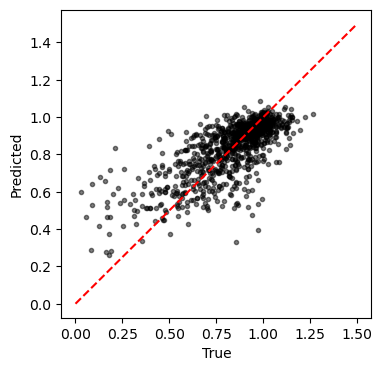

In [15]:
plt.figure(figsize=(4,4)) 
plt.plot(y, yhat, 'k.', alpha=0.5) 
plt.plot([0, 1.5], [0, 1.5], 'r--') 
plt.xlabel('True') 
plt.ylabel('Predicted') 
plt.show() 

## GSNN Explainer to investigate drug response 

In [16]:
# I don't have access to drug names, just the smiles, so we're going to arbitrarily pick one that has a good number of obs

smile = list(drug2code.keys())[200]
print('drug smiles to explain sensitivity:', smile)
subset = drugcell_train[lambda x: x[1] == smile] 
print('# obs', subset.shape[0])
drug_dataset = DrugCellDataset(subset, cell2code, drug2code)
drug_loader = torch.utils.data.DataLoader(drug_dataset, batch_size=100, shuffle=False)
x_cell, x_drug, y = next(iter(drug_loader))
yhat = model(x_cell.to(device), x_drug.to(device)) 

drug smiles to explain sensitivity: CC(C)(C)OC(=O)NC1=CC=C(C=C1)C2=CC(=NO2)C(=O)NCCCCCCC(=O)NO
# obs 37


In [17]:
# first, we'll find some cell latent features that are correlated with the drug sensitivity 

gsnn = model.cell_encoder  

z_cell = gsnn(x_cell.to(device)).detach().cpu().numpy() 

zy_corr_res = {'ix':[], 'corr':[], 'pval':[]}
for i in range(z_cell.shape[1]): 
    zc = z_cell[:, i] 
    corr, pval = spearmanr(zc, y) 
    zy_corr_res['ix'].append(i)
    zy_corr_res['corr'].append(corr)
    zy_corr_res['pval'].append(pval)

zy_corr_res = pd.DataFrame(zy_corr_res).sort_values('pval', ascending=True)
zy_corr_res.head() 


,ix,corr,pval
5,5,0.644381,0.000017
4,4,0.642722,0.000018
0,0,-0.639640,0.000020
1,1,-0.634187,0.000025
3,3,0.393789,0.015889


In [18]:
# use GSNNExplainer to identify the edges that are important for predicting a given target (cell representation) 
torch.cuda.empty_cache() 

explainer = GSNNExplainer(gsnn, data, ignore_cuda=False, gumbel_softmax=True, hard=True, tau0=10, min_tau=0.5, 
                            prior=5, iters=2000, lr=1e-2, weight_decay=0, entropy=10,
                                    beta=1e-3, verbose=True, optimizer=torch.optim.Adam, free_edges=0)

res = explainer.explain(x_cell.to(device), targets=[zy_corr_res.ix.values[0]])      

res.sort_values('score', ascending=False)

iter: 1999 | loss: 0.1916 | mse: 0.0560 | r2: 0.929 | active edges: 172 / 65012 | entropy: 0.0036711
POST-TRAINING EVALUATION (edges > 0.5)
Selected edges: 144 / 65012 (0.2%)
MSE (subset): 0.050052
R² (subset): 0.9365
Variance explained: 0.9413
Correlation: 0.9702


,source,target,score
2287,GO:0007399,GO:0008150,0.999982
1050,GO:0010605,GO:0008150,0.999958
2406,GO:0051606,GO:0008150,0.999883
3154,GO:0071243,GO:0008150,0.999728
3103,GO:0032970,GO:0008150,0.999708
...,...,...,...
38720,GHRL,GO:0016525,0.000026
1094,GO:0031057,GO:0033044,0.000025
56596,PCSK9,GO:0042632,0.000025
13295,ATP1A1,GO:0086002,0.000024


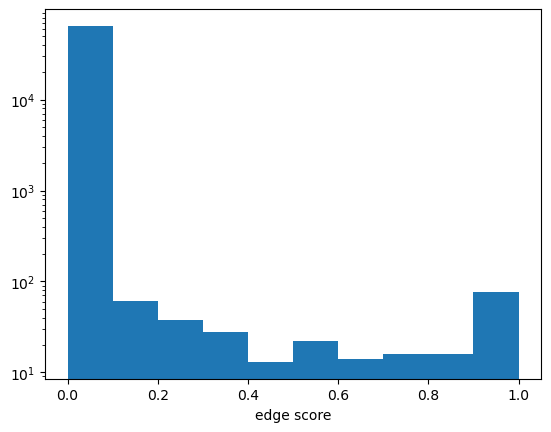

In [19]:
plt.figure() 
plt.hist(res.score)
plt.yscale('log')
plt.xlabel('edge score')
plt.show() 

In [20]:
print('# edges with score > 0.5:', res[lambda x: x.score > 0.5].shape[0])

# edges with score > 0.5: 144


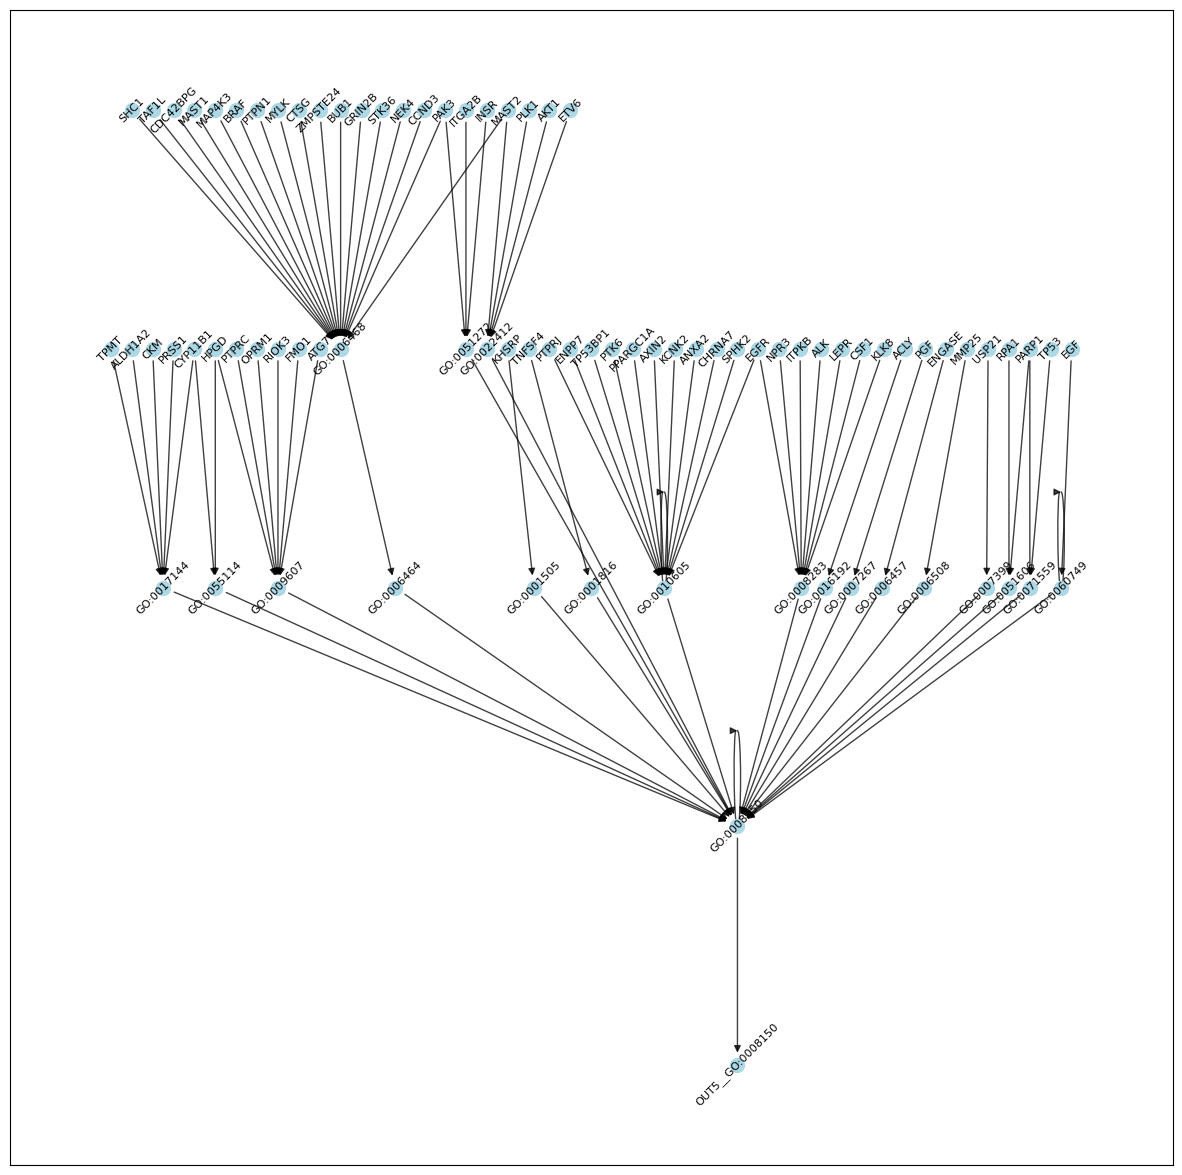

In [21]:
G = nx.from_pandas_edgelist(res[lambda x: x.score > 0.5], source='source', target='target', create_using=nx.DiGraph) 

# remove nodes that are not a descendent of a gene node (leftovers from thresholding) 
# or are not a ancestor of the output node 
n = set() 
for g in input_nodes: 
    if g in G: 
        n.update(nx.descendants(G, g)) 
        n.update(set([g]))

n = n.intersection(set(nx.ancestors(G, output_nodes[zy_corr_res.ix.values[0]])).union(set([output_nodes[zy_corr_res.ix.values[0]]])))

G = G.subgraph(n).copy()  

# use heiarchichal "dot" layout 
H = nx.convert_node_labels_to_integers(G, label_attribute="node_label")
H_layout = nx.nx_pydot.pydot_layout(H, prog="dot")
pos = {H.nodes[n]["node_label"]: p for n, p in H_layout.items()}

plt.figure(figsize=(15,15))
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.75)
nx.draw_networkx_nodes(G, pos, node_size=100, node_color='lightblue')
nl = nx.draw_networkx_labels(G, pos, font_size=8, )

for _, label in nl.items():
    label.set_rotation(45) # Rotate labels by 45 degrees 
    
plt.show() 

## Contrastive Explanation of drug sensitivity

For a given drug we will choose two samples, a sensitive and a resistant, and try to understand which edges can be attributed to the difference in response.  

Note that we are explaining predicted AUC in this example, not just a single gsnn output target (as was the case above). 

In [22]:
ix_res = yhat.argmax()
ix_sens = yhat.argmin()

yhat_res = model(x_cell[ix_res].cuda().view(1,-1), x_drug[ix_res].cuda().view(1,-1))
yhat_sens = model(x_cell[ix_sens].cuda().view(1,-1), x_drug[ix_sens].cuda().view(1,-1))

print(f'yhat_res: {yhat_res.item():.4f} [true: {y[ix_res]:.4f}]')
print(f'yhat_sens: {yhat_sens.item():.4f} [true: {y[ix_sens]:.4f}]')

x1_cell = x_cell[ix_res]
x1_drug = x_drug[ix_res]

x2_cell = x_cell[ix_sens]
x2_drug = x_drug[ix_sens]

x1 = torch.cat([x1_cell, x1_drug], dim=0)
x2 = torch.cat([x2_cell, x2_drug], dim=0)

class wrapper(torch.nn.Module): 
    def __init__(self, model, x_cell_len): 
        super().__init__() 
        self.model = model
        self.edge_index = model.cell_encoder.edge_index 
        self.homo_names = model.cell_encoder.homo_names 
        self.x_cell_len = x_cell_len 

    def __call__(self, x, edge_mask=None): 
        x_cell = x[:, :self.x_cell_len]
        x_drug = x[:, self.x_cell_len:] 
        return self.model(x_cell, x_drug, edge_mask=edge_mask) 


yhat_res: -0.7116 [true: 0.9106]
yhat_sens: -0.7250 [true: -1.7946]


In [23]:
explainer = NoiseTunnel(ContrastiveIGExplainer(
                                wrapper(model.eval(), x_cell.shape[1]), data, n_steps=50), 
                        n_samples=50, noise_std=0.1) 

ig_res = explainer.explain(x1, x2, target_idx=0) 
ig_res = ig_res.sort_values('score', ascending=False)
ig_res.head(10) 

,source,target,score
2939,GO:0045937,GO:0008150,0.018616
1000,GO:0008283,GO:0008150,0.011895
62921,GO:0008150,OUT1__GO:0008150,0.011048
2287,GO:0007399,GO:0008150,0.010690
1796,GO:0051302,GO:0008150,0.010184
2409,GO:0042752,GO:0008150,0.009623
548,GO:0006464,GO:0008150,0.009523
3017,GO:0002504,GO:0008150,0.009221
2125,GO:0016192,GO:0008150,0.007903
1509,GO:0010557,GO:0008150,0.007854


In [24]:
# For the mutations that are most implicated to explain the difference in drug sensitivity, let's confirm that the mutations are indeed different
for g in ig_res[lambda x: x.source.isin(input_nodes)].head(10).source.values: 
    mut_ix = gene2ind[1].values.tolist().index(g) 
    print(f'Gene: {g} >> x1_cell[mut_ix]: {x1_cell[mut_ix]}, x2_cell[mut_ix]: {x2_cell[mut_ix]}')

Gene: HSP90AA1 >> x1_cell[mut_ix]: 0.0, x2_cell[mut_ix]: 1.0
Gene: PARP14 >> x1_cell[mut_ix]: 0.0, x2_cell[mut_ix]: 1.0
Gene: PRKD1 >> x1_cell[mut_ix]: 0.0, x2_cell[mut_ix]: 1.0
Gene: KLK8 >> x1_cell[mut_ix]: 0.0, x2_cell[mut_ix]: 1.0
Gene: FMO1 >> x1_cell[mut_ix]: 0.0, x2_cell[mut_ix]: 1.0
Gene: CASP8 >> x1_cell[mut_ix]: 0.0, x2_cell[mut_ix]: 1.0
Gene: EPX >> x1_cell[mut_ix]: 0.0, x2_cell[mut_ix]: 1.0
Gene: ADAM15 >> x1_cell[mut_ix]: 0.0, x2_cell[mut_ix]: 1.0
Gene: ITGB7 >> x1_cell[mut_ix]: 0.0, x2_cell[mut_ix]: 1.0
Gene: LTK >> x1_cell[mut_ix]: 0.0, x2_cell[mut_ix]: 1.0


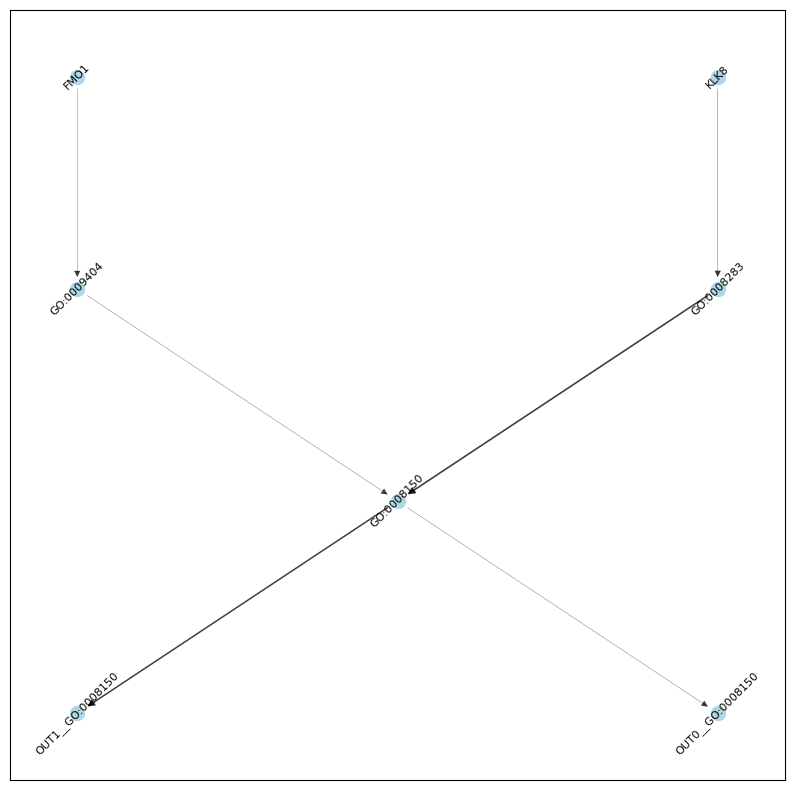

In [25]:
G = nx.from_pandas_edgelist(ig_res[lambda x: x.score > 0.002], source='source', target='target', edge_attr='score', create_using=nx.DiGraph) 

# TO make the graph more readable... 
# subset to only nodes that are ancestors or descendants of GO:0008150 (biological_process) AND descendent of a gene node
n = nx.ancestors(G, 'GO:0008150').union(nx.descendants(G, 'GO:0008150')).union(set(['GO:0008150']))
n2 = set() 
for g in input_nodes: 
    if g in G: 
        n2.update(nx.descendants(G, g)) 
        n2.update(set([g])) 
n = n.intersection(n2)

G = G.subgraph(n).copy()  

# use heiarchichal "dot" layout 
H = nx.convert_node_labels_to_integers(G, label_attribute="node_label")
H_layout = nx.nx_pydot.pydot_layout(H, prog="dot")
pos = {H.nodes[n]["node_label"]: p for n, p in H_layout.items()}

edge_widths = [G.edges[e]['score'] * 100 for e in G.edges]

plt.figure(figsize=(10,10))
nx.draw_networkx_edges(G, pos, alpha=0.75, width=edge_widths)
nx.draw_networkx_nodes(G, pos, node_size=100, node_color='lightblue')
nl = nx.draw_networkx_labels(G, pos, font_size=8, )

for _, label in nl.items():
    label.set_rotation(45) # Rotate labels by 45 degrees

plt.show()  

## Node activations 

In [26]:
torch.cuda.empty_cache() 
x_cell, x_drug, y = next(iter(test_loader))

with torch.no_grad(): 
    node_acts = model.cell_encoder.get_node_activations(x_cell.cuda(), agg='sum')

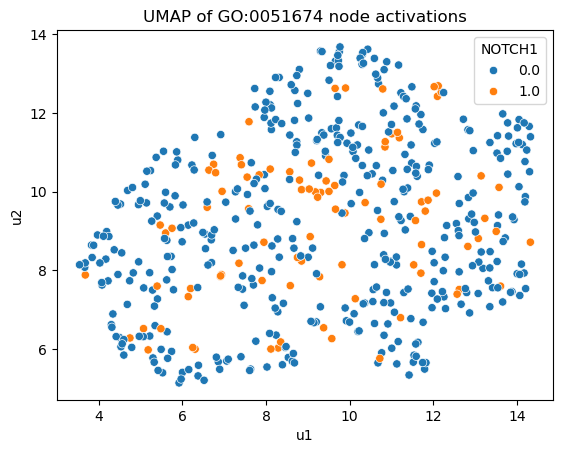

In [27]:
reducer = umap.UMAP(n_components=2, min_dist=0.5, n_neighbors=25)
u = reducer.fit_transform(node_acts['GO:0006955'].detach().cpu().numpy())

df = pd.DataFrame(u, columns=['u1', 'u2'])

for i,row in gene2ind.iterrows(): 
    df = df.assign(**{row[1]: x_cell[:,i]})

plt.figure() 
sbn.scatterplot(x='u1', y='u2', hue='NOTCH1', data=df)
plt.title('UMAP of GO:0051674 node activations')
plt.show() 


## Node attention 

(If using `node_attn=True`)

In [28]:
GO_TERM = 'GO:0042737' # The chemical reactions and pathways resulting in the breakdown of a drug

torch.cuda.empty_cache() 

attns = [] 
with torch.no_grad(): 
    for xc in x_cell.to(device): 
        attn_res = model.cell_encoder.get_node_attention(xc) 
        attns.append(attn_res.loc[GO_TERM].values.max())
attns = np.array(attns)

reducer = umap.UMAP(n_components=2, min_dist=1.)
u = reducer.fit_transform(node_acts[GO_TERM])

df = pd.DataFrame(u, columns=['u1', 'u2'])
df = df.assign(attn = attns)

plt.figure() 
sbn.scatterplot(x='u1', y='u2', hue='attn', data=df, alpha=0.5)
plt.title(f'UMAP of {GO_TERM} node activations')
plt.show() 

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [ ]:
attns

NameError: name 'attns' is not defined

<Axes: xlabel='attn', ylabel='response'>

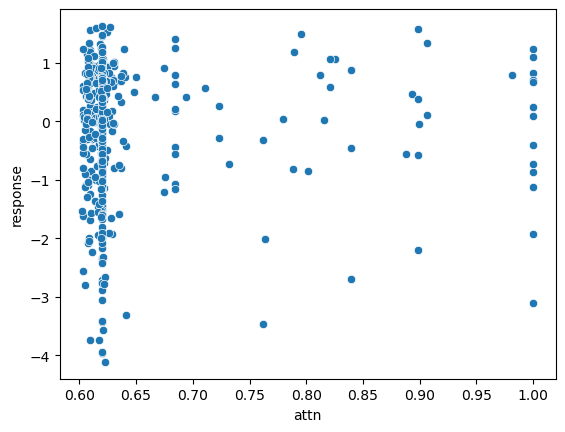

In [ ]:
df = df.assign(response = y.detach().cpu().numpy())

sbn.scatterplot(x='attn', y='response', data=df, alpha=1)